<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#loading-data" data-toc-modified-id="loading-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>loading data</a></span></li><li><span><a href="#feature-engineering" data-toc-modified-id="feature-engineering-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>feature engineering</a></span></li><li><span><a href="#cross-validation" data-toc-modified-id="cross-validation-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>cross validation</a></span></li><li><span><a href="#submission" data-toc-modified-id="submission-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>submission</a></span></li></ul></div>

In [1]:
%matplotlib inline

import sys
import pandas as pd
import numpy as np

import os
import gc

import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option("max_colwidth", -1)
pd.set_option("max_columns", 500)
pd.set_option("max_rows", 500)

plt.style.use('fivethirtyeight')
plt.rcParams["axes.labelsize"] = 16
plt.rcParams["xtick.labelsize"] = 14
plt.rcParams["ytick.labelsize"] = 14

from sklearn.metrics import log_loss
from sklearn.ensemble import RandomForestClassifier
from tqdm.notebook import tqdm as tqdm

### loading data

In [2]:
train = pd.read_csv("Train.csv", index_col=None)
print(train.shape)
train.head()

(543, 8)


,City,Location_Score,Internal_Audit_Score,External_Audit_Score,Fin_Score,Loss_score,Past_Results,IsUnderRisk
0,2,8.032,14,8,3,6,0,1
1,31,77.730,8,3,3,8,1,0
2,40,59.203,3,12,11,3,0,1
3,12,73.080,4,5,7,6,0,0
4,4,15.666,13,15,6,7,2,1


In [3]:
target = 'IsUnderRisk'
cat_cols = ['City']
num_cols = [col for col in train.columns if col not in [target]+cat_cols]; num_cols

['Location_Score',
 'Internal_Audit_Score',
 'External_Audit_Score',
 'Fin_Score',
 'Loss_score',
 'Past_Results']

In [4]:
test = pd.read_csv("Test.csv", index_col=None)
print(test.shape)
test.head()

(233, 7)


,City,Location_Score,Internal_Audit_Score,External_Audit_Score,Fin_Score,Loss_score,Past_Results
0,41,18.272,13,12,9,7,0
1,17,64.799,6,10,7,4,1
2,31,68.890,3,3,7,8,0
3,3,16.492,15,10,7,4,1
4,9,17.178,7,3,8,3,1


### feature engineering

In [5]:
def feature_engineering(df):
#     df['Audit_Score_avg'] = np.mean((df['Internal_Audit_Score'], df['External_Audit_Score']), axis=0)
#     df['Audit_Score_diff'] = df['Internal_Audit_Score'] - df['External_Audit_Score']
    df['Audit_Score_overall_avg'] = df[['Internal_Audit_Score', 'External_Audit_Score', 
                                        'Fin_Score', 'Loss_score']].mean(axis=1) 
    
    df['Audit_Score_overall_std'] = df[['Internal_Audit_Score', 'External_Audit_Score', 
                                        'Fin_Score', 'Loss_score']].std(axis=1) 
    
    df['Audit_Score_overall_min'] = df[['Internal_Audit_Score', 'External_Audit_Score', 
                                        'Fin_Score', 'Loss_score']].max(axis=1) 
    
    df['Audit_Score_overall_max'] = df[['Internal_Audit_Score', 'External_Audit_Score', 
                                        'Fin_Score', 'Loss_score']].min(axis=1) 
    
    return df

In [6]:
train = feature_engineering(train)
test = feature_engineering(test)

In [7]:
train.head()

,City,Location_Score,Internal_Audit_Score,External_Audit_Score,Fin_Score,Loss_score,Past_Results,IsUnderRisk,Audit_Score_overall_avg,Audit_Score_overall_std,Audit_Score_overall_min,Audit_Score_overall_max
0,2,8.032,14,8,3,6,0,1,7.75,4.645787,14,3
1,31,77.730,8,3,3,8,1,0,5.50,2.886751,8,3
2,40,59.203,3,12,11,3,0,1,7.25,4.924429,12,3
3,12,73.080,4,5,7,6,0,0,5.50,1.290994,7,4
4,4,15.666,13,15,6,7,2,1,10.25,4.425306,15,6


In [8]:
test.head()

,City,Location_Score,Internal_Audit_Score,External_Audit_Score,Fin_Score,Loss_score,Past_Results,Audit_Score_overall_avg,Audit_Score_overall_std,Audit_Score_overall_min,Audit_Score_overall_max
0,41,18.272,13,12,9,7,0,10.25,2.753785,13,7
1,17,64.799,6,10,7,4,1,6.75,2.500000,10,4
2,31,68.890,3,3,7,8,0,5.25,2.629956,8,3
3,3,16.492,15,10,7,4,1,9.00,4.690416,15,4
4,9,17.178,7,3,8,3,1,5.25,2.629956,8,3


### cross validation

In [9]:
# import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV

preds = []

valid_score_list = []
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=12121212) 
for i, (train_ind, test_ind) in enumerate(cv.split(train, train[target])):
    data_train = train.iloc[train_ind].reset_index(drop=True)
    data_valid = train.iloc[test_ind].reset_index(drop=True)
    
    clf = RandomForestClassifier(n_jobs=-1, n_estimators=3000, class_weight='balanced')
    X_train = data_train.drop([target], axis=1)
    X_valid = data_valid.drop([target], axis=1)
    X_test = test.copy()

    clf.fit(X_train, data_train[target])
    
    valid_prediction = clf.predict_proba(X_valid)
    valid_score = log_loss(data_valid[target], valid_prediction)
    valid_score_list.append(valid_score)
    print("FOLD:{} Score:{:0.2f}".format(i+1, valid_score))
    
    preds.append(clf.predict_proba(X_test))
    
print("CV score is {}".format(np.mean(valid_score_list)))

FOLD:1 Score:0.35
FOLD:2 Score:0.26
FOLD:3 Score:0.30
FOLD:4 Score:0.29
FOLD:5 Score:0.28
CV score is 0.2974585480261872


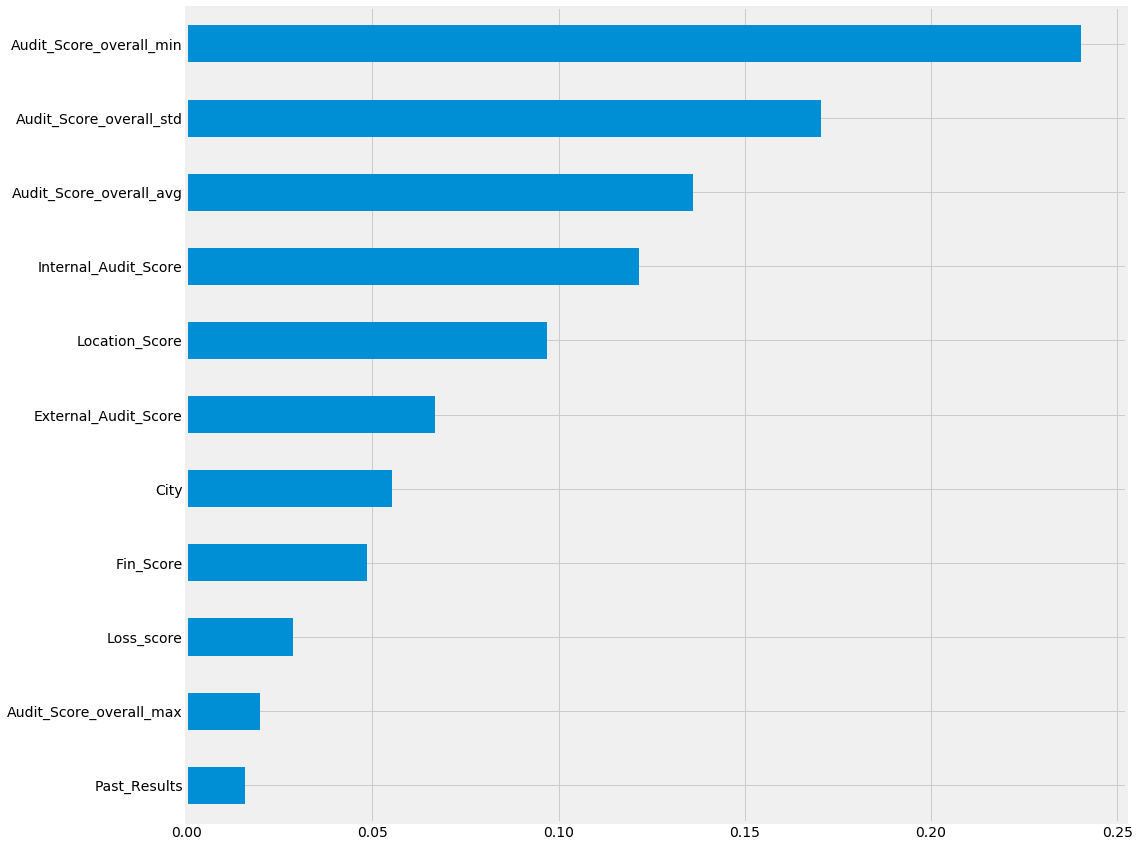

In [10]:
pd.Series(clf.feature_importances_, index=X_train.columns).sort_values().plot(kind='barh', figsize=(15,15))

### submission

In [11]:
prediction = np.mean(preds, axis=0)

In [12]:
sub = pd.DataFrame(prediction, columns=[0,1])
sub.to_excel("model_rf_v6.xlsx", index=None)
sub.head()

,0,1
0,0.000600,0.999400
1,0.078867,0.921133
2,0.737600,0.262400
3,0.000000,1.000000
4,0.354000,0.646000
